In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import pytensor.tensor as pt
from marginaleffects import datagrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_path = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectricCompany/data/electric.csv"
raw_df = pl.read_csv(data_path).drop(["supp", ""]).sort(["grade", "pair_id"])

raw_df.head()

post_test,pre_test,grade,treatment,pair_id
f64,f64,i64,i64,i64
48.9,13.8,1,1,1
52.3,12.3,1,0,1
70.5,16.5,1,1,2
55.0,14.4,1,0,2
89.7,18.5,1,1,3


In [4]:
numeric_features = ["pre_test", "post_test"]
ordinal_features = ["grade", "pair_id"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric_features),
        ("ord", OrdinalEncoder(dtype=int), ordinal_features),
    ],
    remainder="passthrough",
).set_output(transform="polars")


df = preprocessor.fit_transform(raw_df)
df.columns = [col.split("__")[-1] for col in df.columns]

df.head()

pre_test,post_test,grade,pair_id,treatment
f64,f64,i64,i64,i64
-1.726248,-2.724052,0,0,1
-1.770568,-2.532096,0,0,0
-1.646472,-1.504567,0,1,1
-1.70852,-2.37966,0,1,0
-1.587379,-0.42058,0,2,1


In [5]:
x_columns = ["pre_test"]
x_df = df[x_columns]

x_df.head()

pre_test
f64
-1.726248
-1.770568
-1.646472
-1.70852
-1.587379


In [6]:
n_grades = len(preprocessor["ord"].categories_[ordinal_features.index("grade")])
n_pairs = len(preprocessor["ord"].categories_[ordinal_features.index("pair_id")])

coords = {
    # covariates
    "covariates": x_df.columns,
    # grade
    "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
    # object categories (groups)
    "pair_id": preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    # index
    "obs_idx": np.arange(len(df)),
}

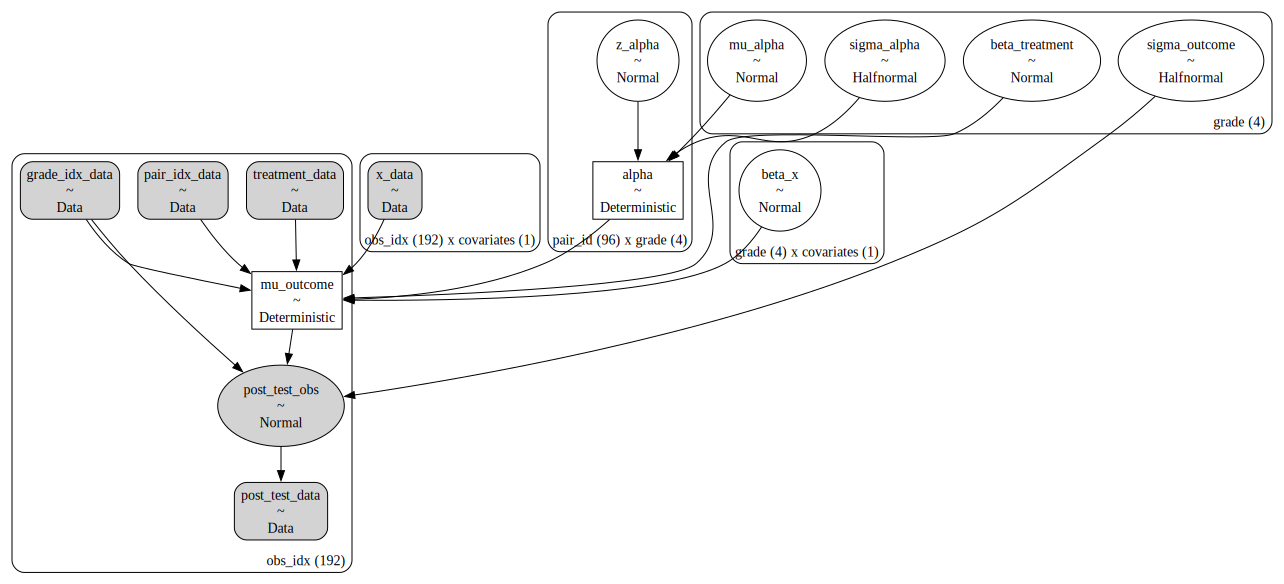

In [7]:
with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    # covariates
    x_data = pm.Data("x_data", x_df, dims=("obs_idx", "covariates"))
    # grade
    grade_idx_data = pm.Data("grade_idx_data", df["grade"].to_numpy(), dims="obs_idx")
    # object categories
    pair_idx_data = pm.Data("pair_idx_data", df["pair_id"].to_numpy(), dims="obs_idx")
    # treatment
    treatment_data = pm.Data(
        "treatment_data", df["treatment"].to_numpy(), dims=("obs_idx")
    )
    # outcome
    post_test_data = pm.Data(
        "post_test_data", df["post_test"].to_numpy(), dims="obs_idx"
    )

    # --- Priors ---
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1, dims=("grade"))
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1, dims=("grade"))
    z_alpha = pm.Normal("z_alpha", mu=0, sigma=1, dims=("pair_id", "grade"))

    beta_treatment = pm.Normal("beta_treatment", mu=0, sigma=1, dims=("grade"))
    beta_x = pm.Normal("beta_x", mu=0, sigma=1, dims=("grade", "covariates"))

    sigma_outcome = pm.HalfNormal("sigma_outcome", sigma=1, dims=("grade"))

    # --- Parametrization ---
    # Non-centered parametrization for the random intercepts
    alpha = pm.Deterministic(
        "alpha", mu_alpha + z_alpha * sigma_alpha, dims=("pair_id", "grade")
    )

    mu_outcome = pm.Deterministic(
        "mu_outcome",
        alpha[pair_idx_data, grade_idx_data]
        + beta_treatment[grade_idx_data] * treatment_data
        + (beta_x[grade_idx_data] * x_data).sum(axis=-1),
        dims=("obs_idx"),
    )

    # --- Likelihood ---
    pm.Normal(
        "post_test_obs",
        mu=mu_outcome,
        sigma=sigma_outcome[grade_idx_data],
        observed=post_test_data,
        dims="obs_idx",
    )


pm.model_to_graphviz(model)

In [8]:
with model:
    idata = pm.sample_prior_predictive()

Sampling: [beta_treatment, beta_x, mu_alpha, post_test_obs, sigma_alpha, sigma_outcome, z_alpha]


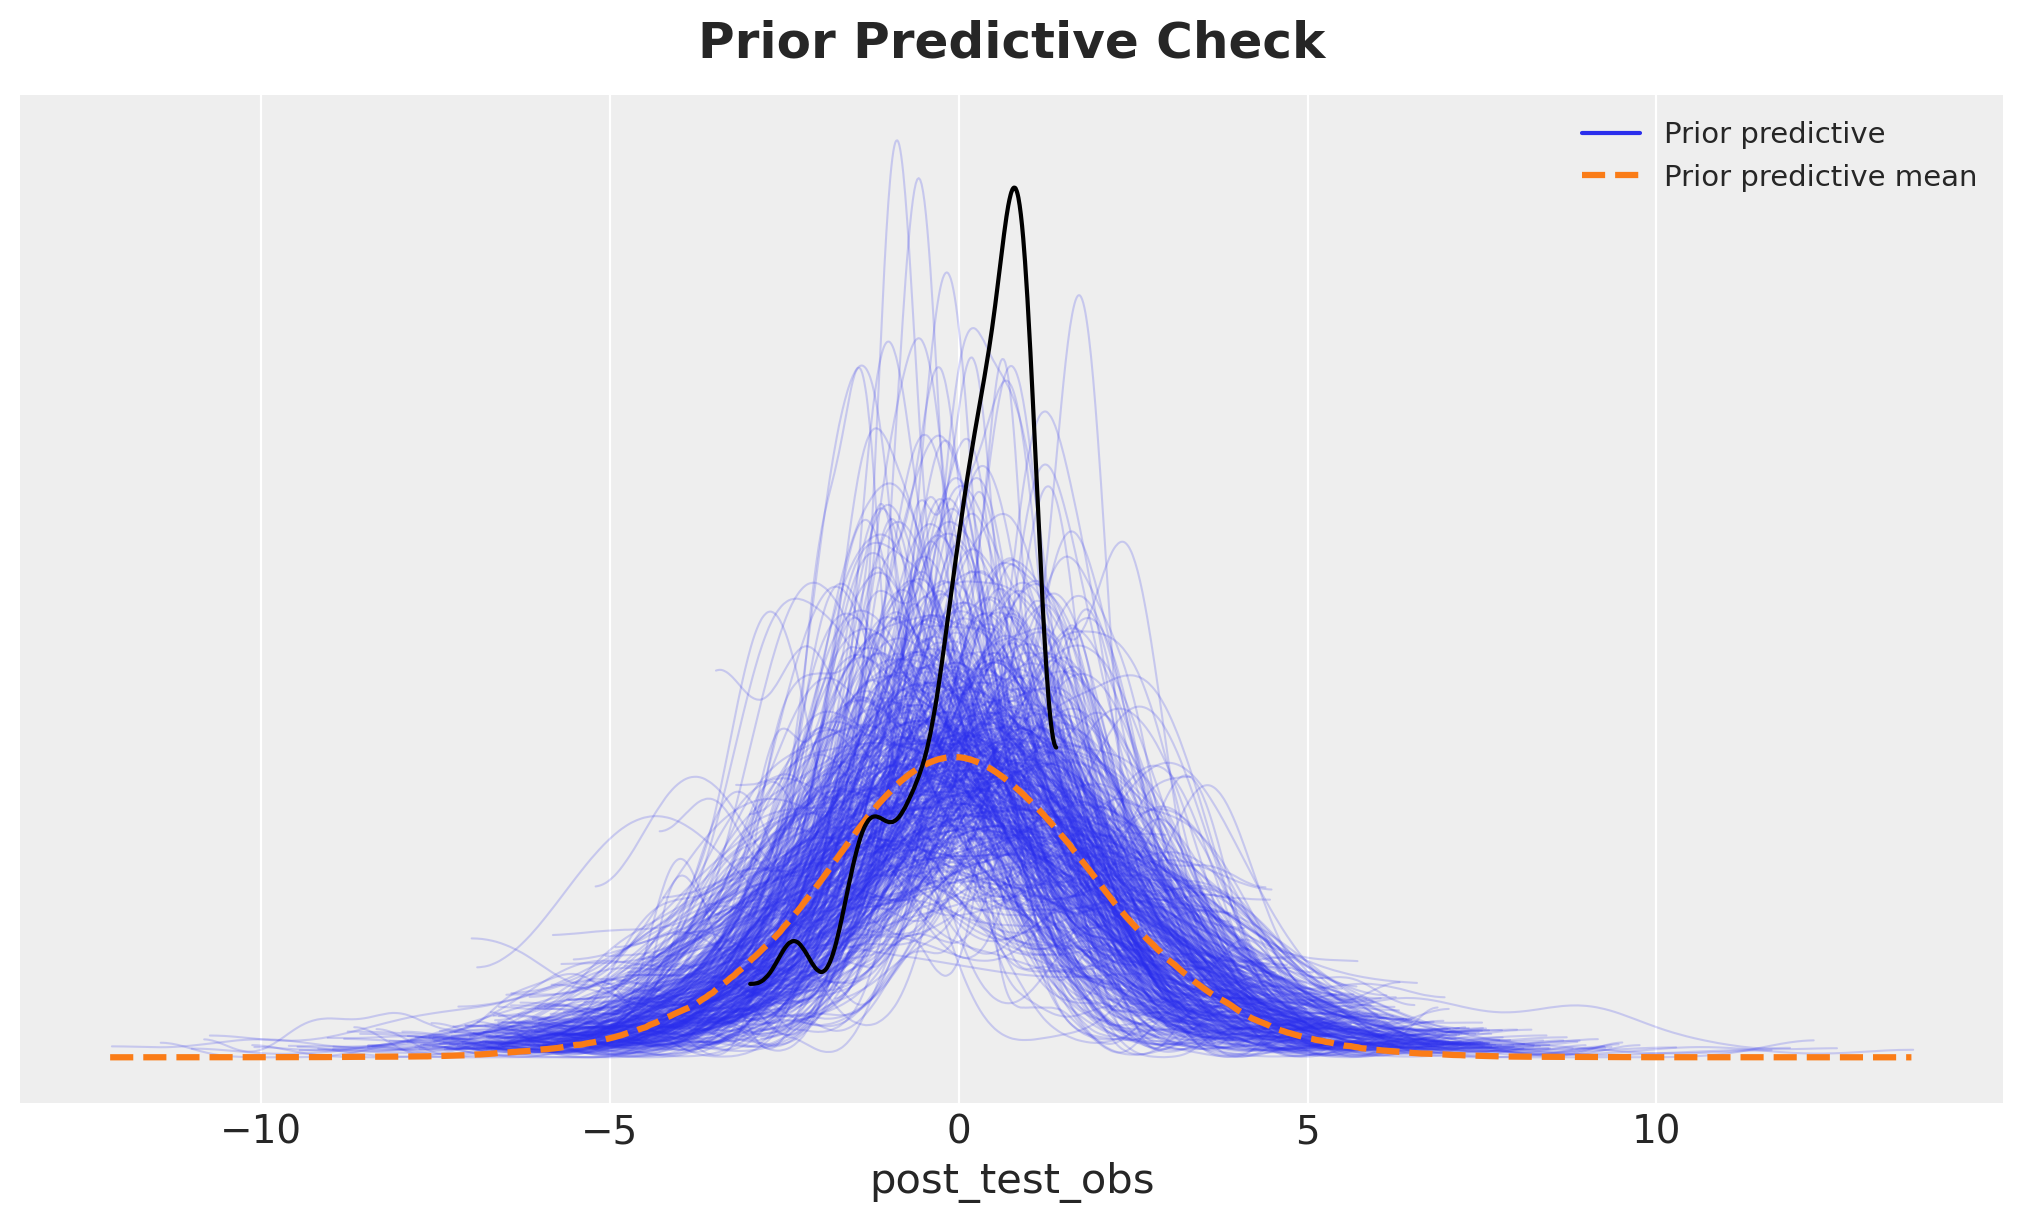

In [9]:
fig, ax = plt.subplots()
az.plot_ppc(idata, group="prior", ax=ax)
az.plot_dist(df["post_test"].to_numpy(), color="black", ax=ax)
ax.set_title("Prior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

In [10]:
with model:
    idata.extend(
        pm.sample(
            tune=1_500,
            draws=1_000,
            target_accept=0.9,
            chains=4,
            nuts_sampler="numpyro",
        )
    )

    idata.extend(pm.sample_posterior_predictive(idata))

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [post_test_obs]


Output()

In [11]:
idata["sample_stats"]["diverging"].sum().item()

0

In [12]:
az.summary(
    idata,
    var_names=[
        "beta_treatment",
        "beta_x",
        "mu_alpha",
        "sigma_alpha",
        "sigma_outcome",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment[1],0.470,0.144,0.213,0.758,0.002,0.003,3825.0,2877.0,1.00
beta_treatment[2],0.235,0.057,0.131,0.349,0.001,0.001,3432.0,2922.0,1.00
beta_treatment[3],0.106,0.043,0.024,0.183,0.001,0.001,3668.0,2977.0,1.00
beta_treatment[4],0.093,0.036,0.024,0.158,0.001,0.001,4249.0,2799.0,1.00
"beta_x[1, pre_test]",1.536,0.519,0.535,2.463,0.012,0.008,1725.0,2149.0,1.00
"beta_x[2, pre_test]",1.549,0.113,1.334,1.751,0.003,0.002,1824.0,2778.0,1.00
"beta_x[3, pre_test]",1.308,0.081,1.161,1.464,0.002,0.001,2223.0,2538.0,1.00
"beta_x[4, pre_test]",1.276,0.087,1.121,1.451,0.002,0.001,1467.0,2002.0,1.00
mu_alpha[1],0.956,0.861,-0.663,2.538,0.020,0.013,1767.0,2111.0,1.00
mu_alpha[2],-0.151,0.056,-0.250,-0.042,0.001,0.001,1715.0,2472.0,1.00


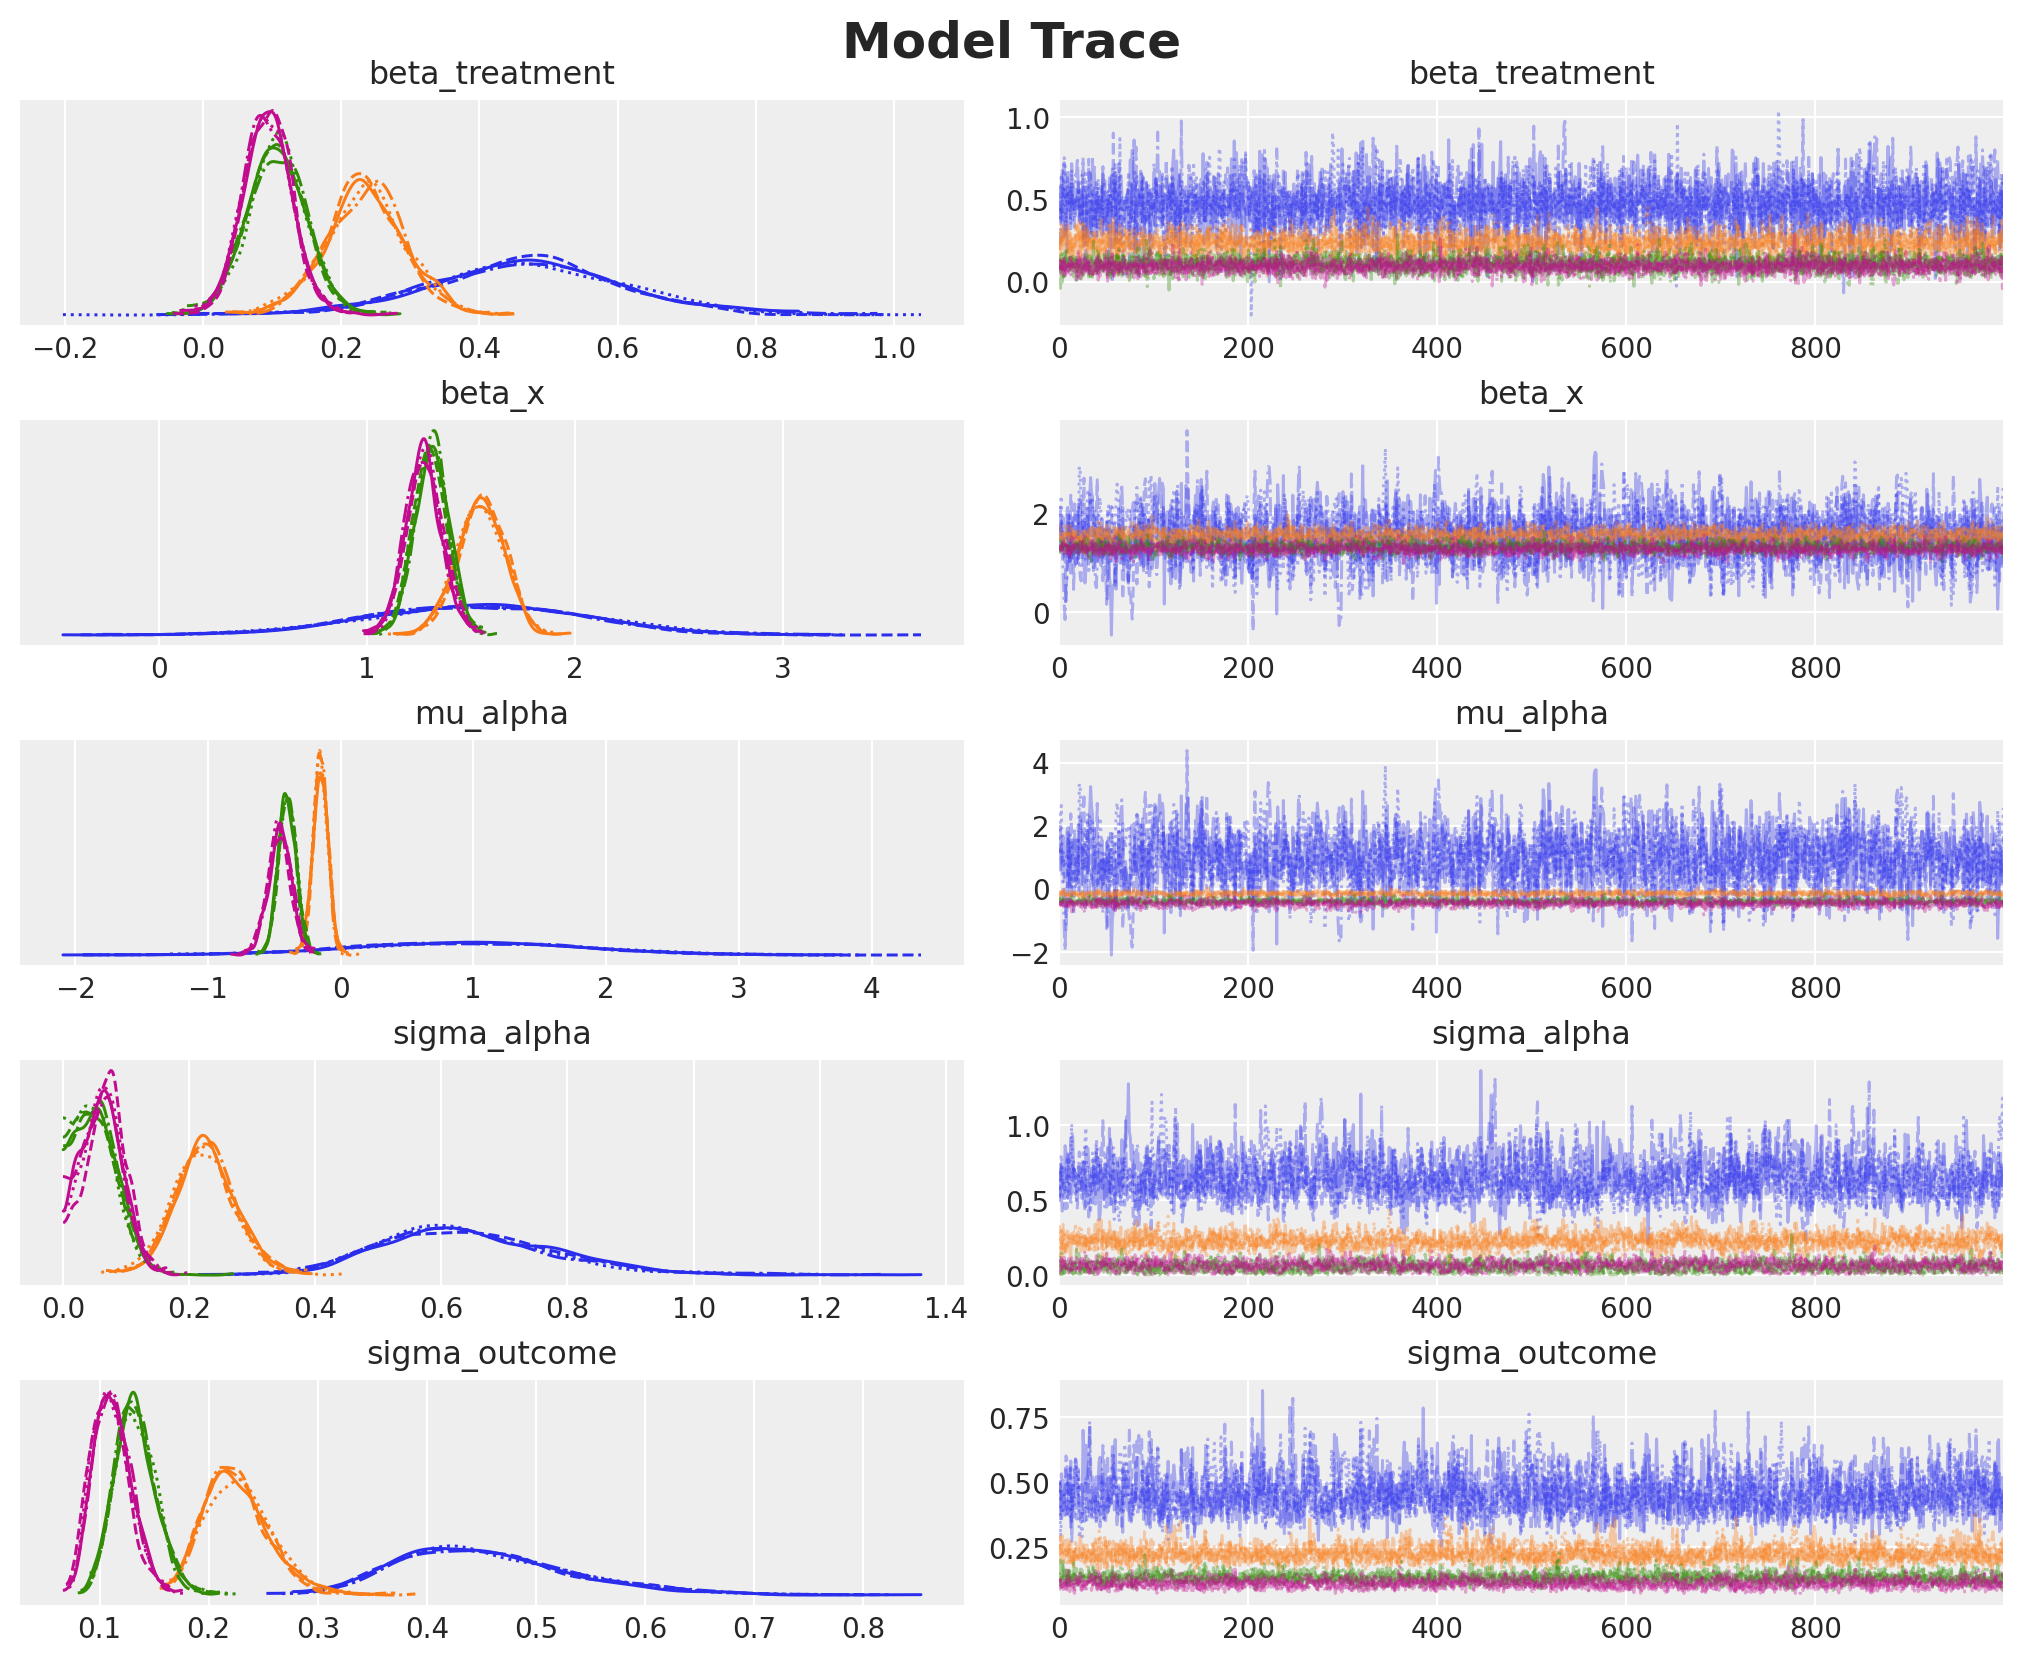

In [13]:
axes = az.plot_trace(
    idata,
    var_names=[
        "beta_treatment",
        "beta_x",
        "mu_alpha",
        "sigma_alpha",
        "sigma_outcome",
    ],
    figsize=(10, 8),
)


plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold", y=1.02);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

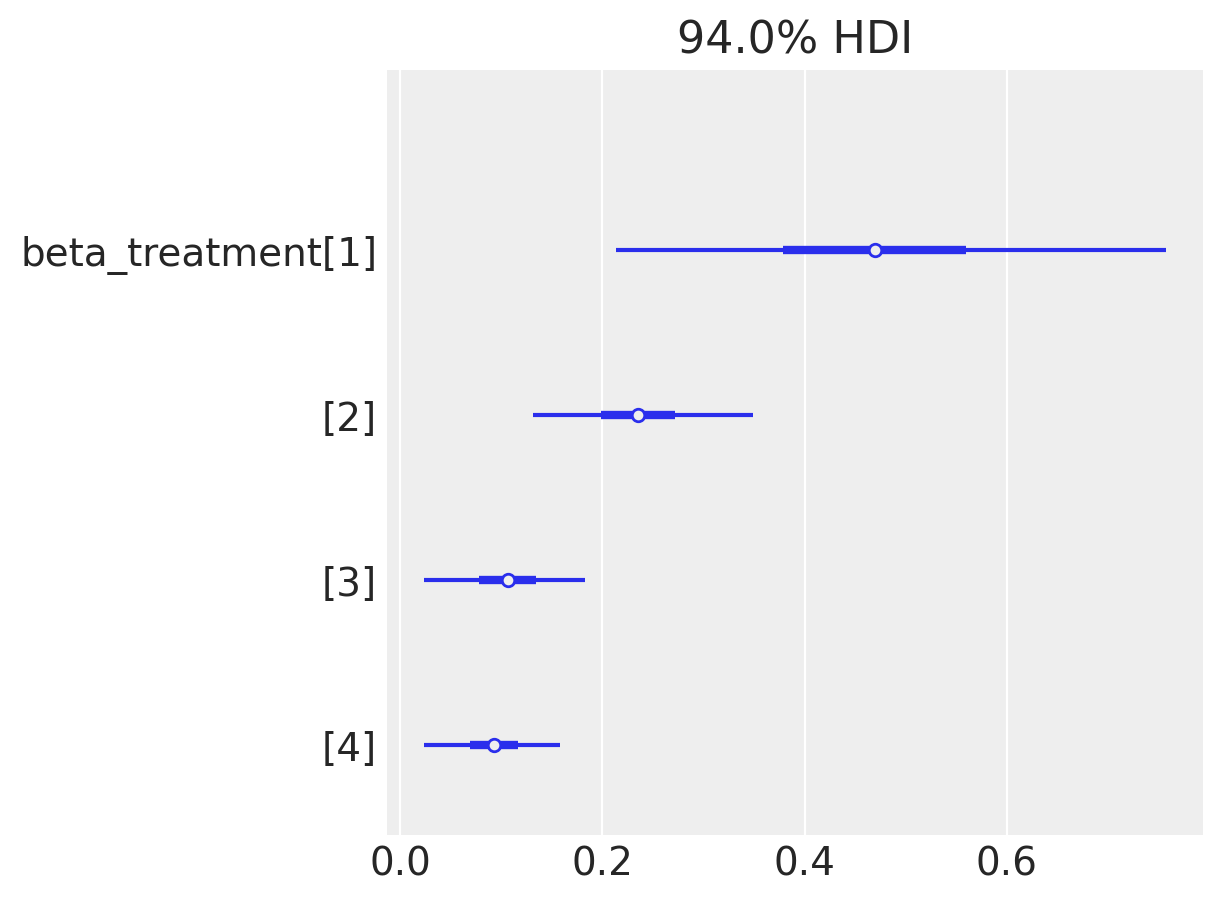

In [14]:
az.plot_forest(idata, combined=True, var_names=["beta_treatment"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

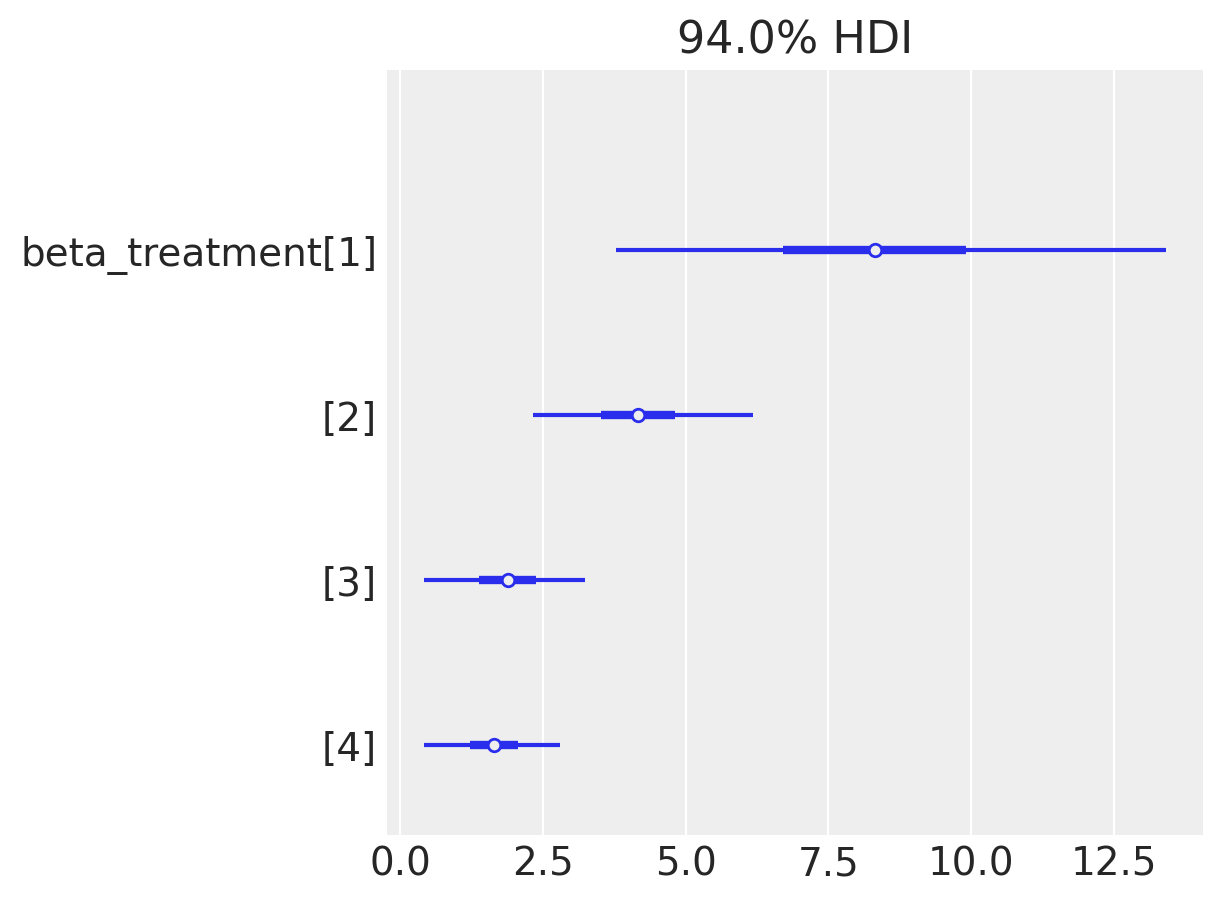

In [15]:
az.plot_forest(
    idata["posterior"]["beta_treatment"]
    * preprocessor["num"].scale_[numeric_features.index("post_test")],
    combined=True,
)

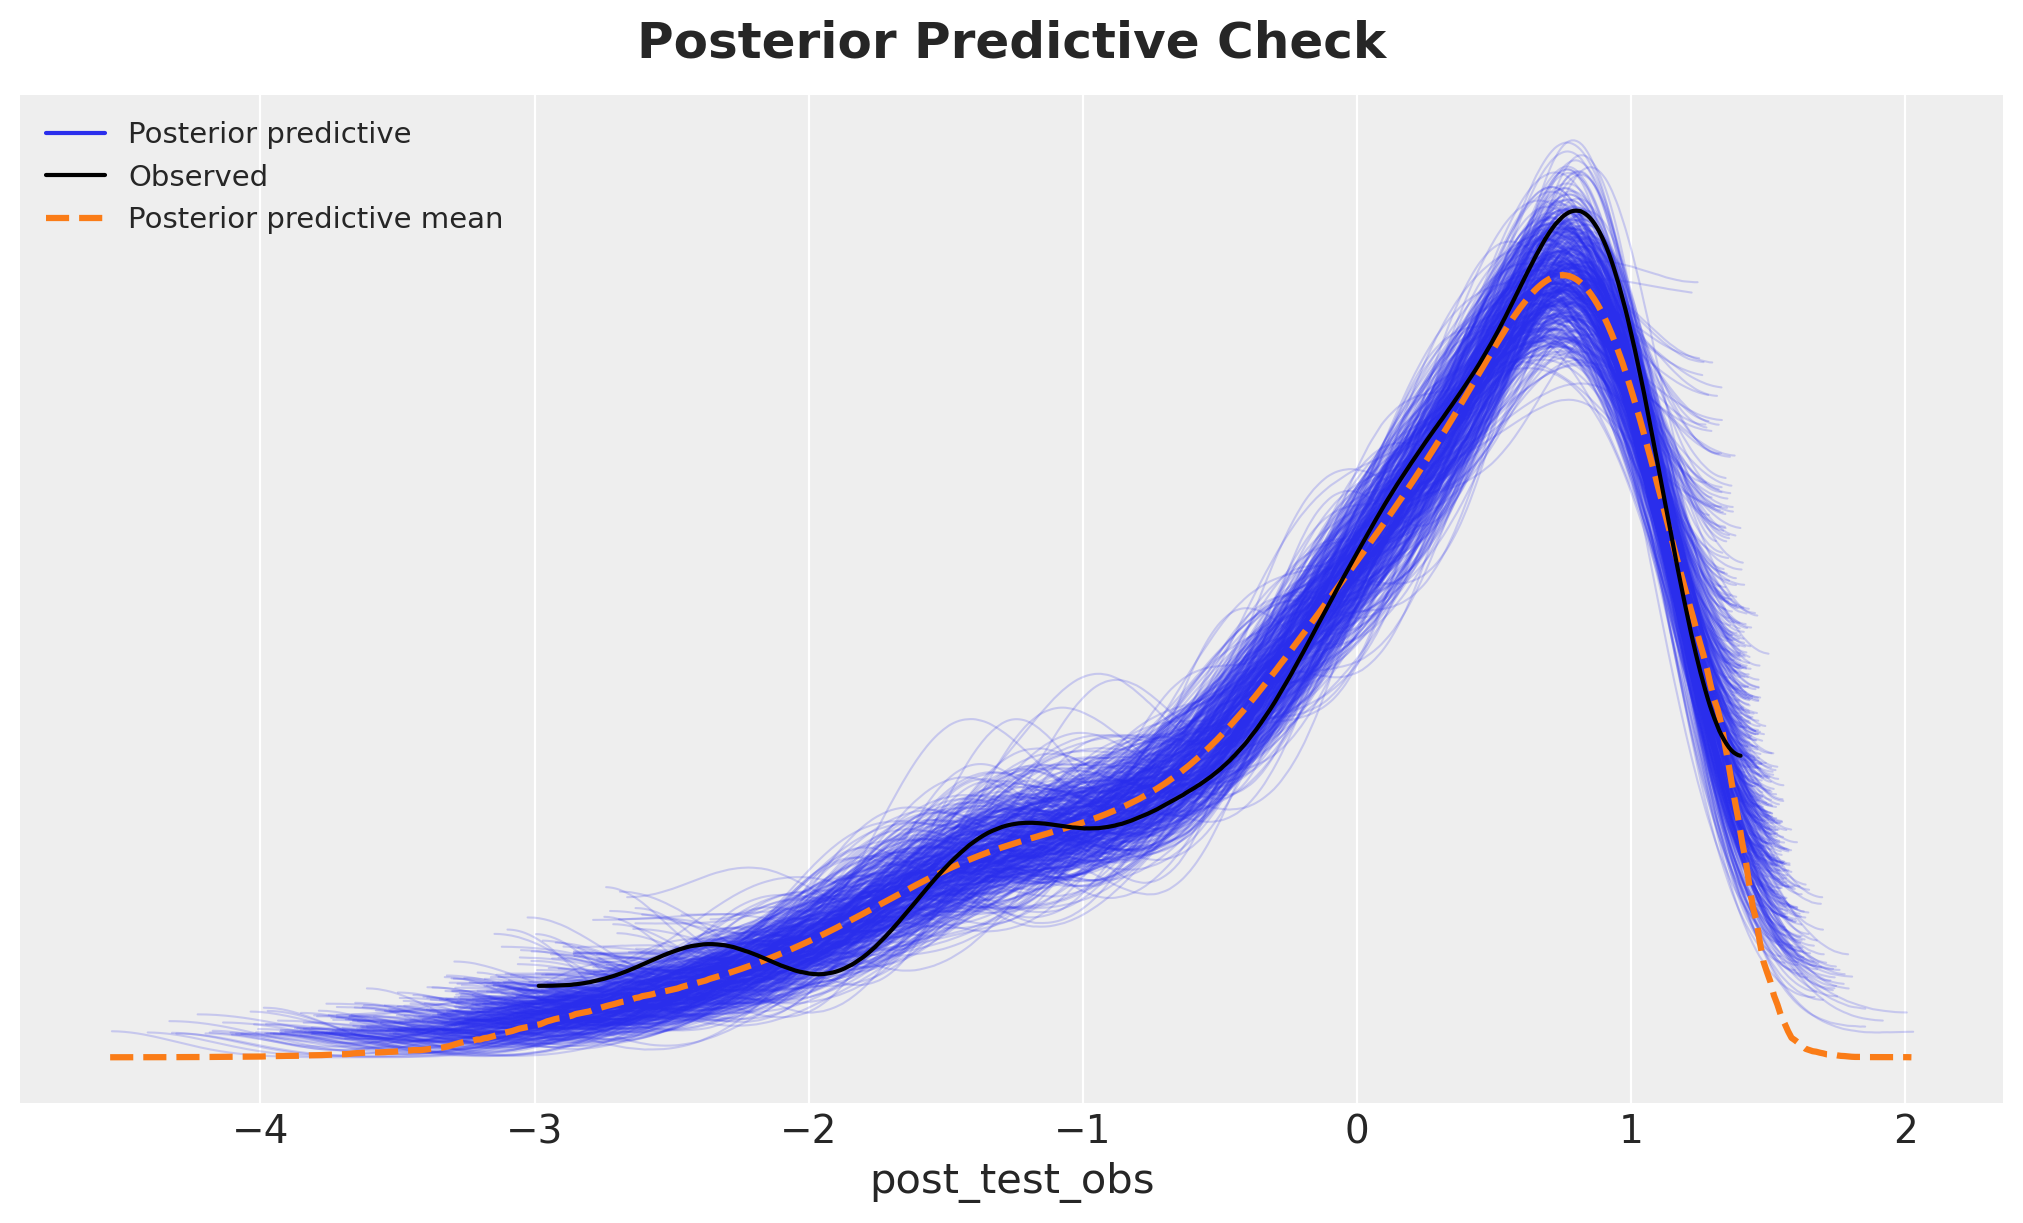

In [16]:
fig, ax = plt.subplots()
az.plot_ppc(idata, group="posterior", num_pp_samples=500, ax=ax)
ax.set_title("Posterior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

In [17]:
raw_df_control_grid = datagrid(
    newdata=raw_df,
    treatment=0,
    grade=preprocessor["ord"].categories_[ordinal_features.index("grade")],
    pair_id=preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    pre_test=np.linspace(raw_df["pre_test"].min(), raw_df["pre_test"].max(), 10),
)

df_control_grid = preprocessor.transform(raw_df_control_grid)
df_control_grid.columns = [col.split("__")[-1] for col in df_control_grid.columns]
x_df_control_grid = df_control_grid[x_columns]

raw_df_treatment_grid = datagrid(
    newdata=raw_df,
    treatment=1,
    grade=preprocessor["ord"].categories_[ordinal_features.index("grade")],
    pair_id=preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    pre_test=np.linspace(raw_df["pre_test"].min(), raw_df["pre_test"].max(), 10),
)

df_treatment_grid = preprocessor.transform(raw_df_treatment_grid)
df_treatment_grid.columns = [col.split("__")[-1] for col in df_treatment_grid.columns]
x_df_treatment_grid = df_treatment_grid[x_columns]

In [18]:
with model:
    pm.set_data(
        new_data={
            "x_data": x_df_control_grid,
            "grade_idx_data": df_control_grid["grade"].to_numpy(),
            "pair_idx_data": df_control_grid["pair_id"].to_numpy(),
            "treatment_data": df_control_grid["treatment"].to_numpy(),
            "post_test_data": df_control_grid["post_test"].to_numpy(),
        },
        coords={
            "covariates": x_df_control_grid.columns,
            "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
            "pair_id": preprocessor["ord"].categories_[
                ordinal_features.index("pair_id")
            ],
            "obs_idx": np.arange(len(df_control_grid)),
        },
    )

    posterior_predictive_control = pm.sample_posterior_predictive(
        idata, var_names=["post_test_obs", "mu_outcome"]
    )

Sampling: [post_test_obs]


Output()

In [19]:
with model:
    pm.set_data(
        new_data={
            "x_data": x_df_treatment_grid,
            "grade_idx_data": df_treatment_grid["grade"].to_numpy(),
            "pair_idx_data": df_treatment_grid["pair_id"].to_numpy(),
            "treatment_data": df_treatment_grid["treatment"].to_numpy(),
            "post_test_data": df_treatment_grid["post_test"].to_numpy(),
        },
        coords={
            "covariates": x_df_treatment_grid.columns,
            "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
            "pair_id": preprocessor["ord"].categories_[
                ordinal_features.index("pair_id")
            ],
            "obs_idx": np.arange(len(df_treatment_grid)),
        },
    )

    posterior_predictive_treatment = pm.sample_posterior_predictive(
        idata, var_names=["post_test_obs", "mu_outcome"]
    )

Sampling: [post_test_obs]


Output()

In [20]:
control_mask = (
    raw_df_control_grid.select(pl.col("grade").eq(pl.lit(1))).to_numpy().flatten()
)
control_posterior_grade = posterior_predictive_control["posterior_predictive"][
    "mu_outcome"
][:, :, control_mask]

original_scale_control_posterior_grade = (
    control_posterior_grade
    * preprocessor["num"].scale_[numeric_features.index("post_test")]
    + preprocessor["num"].mean_[numeric_features.index("post_test")]
)

treatment_mask = (
    raw_df_treatment_grid.select(pl.col("grade").eq(pl.lit(1))).to_numpy().flatten()
)
treatment_posterior_grade = posterior_predictive_treatment["posterior_predictive"][
    "mu_outcome"
][:, :, treatment_mask]

original_scale_treatment_posterior_grade = (
    treatment_posterior_grade
    * preprocessor["num"].scale_[numeric_features.index("post_test")]
    + preprocessor["num"].mean_[numeric_features.index("post_test")]
)

<Axes: title={'center': 'beta_treatment'}>

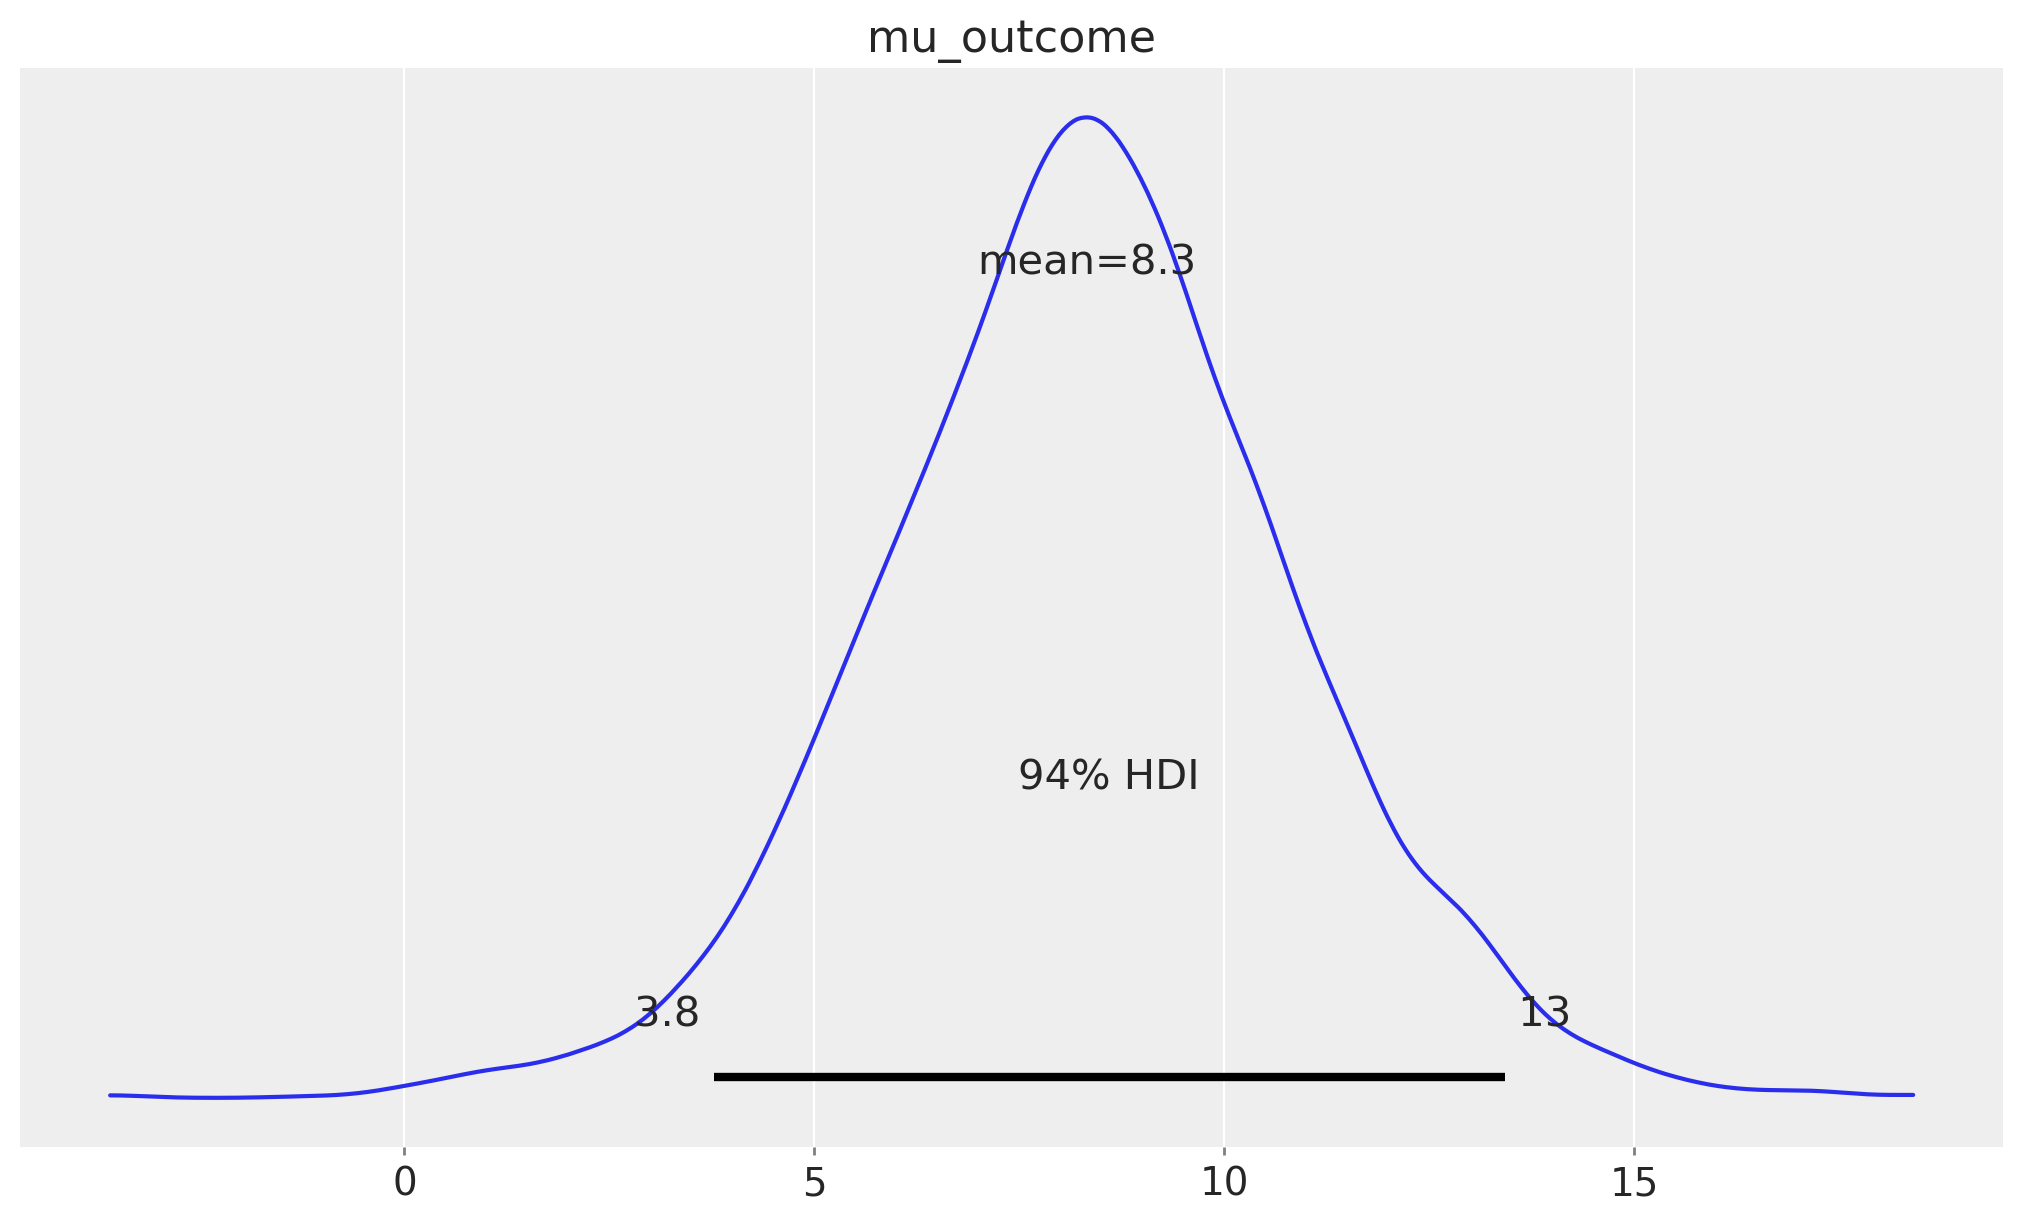

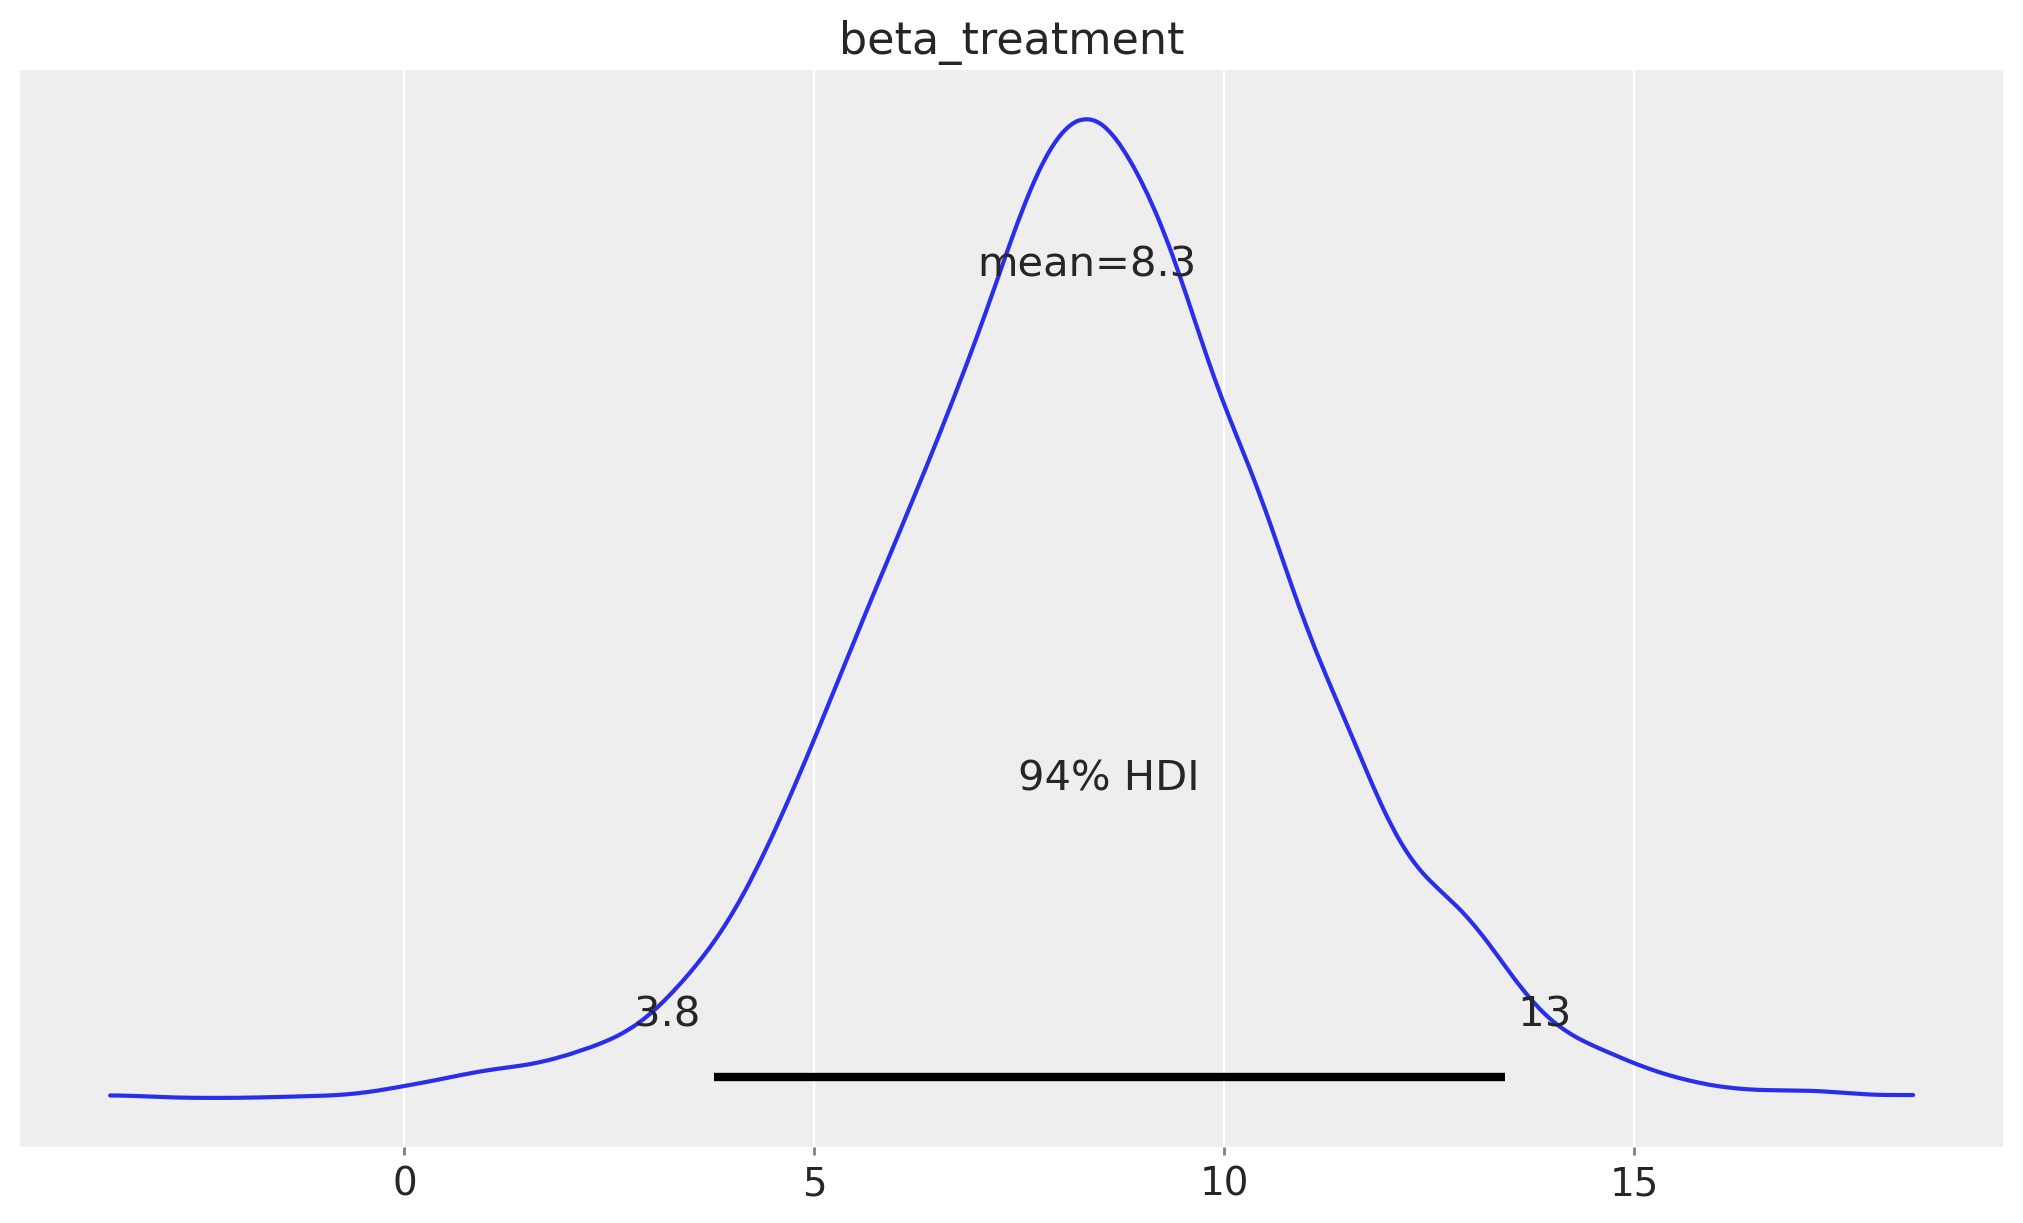

In [21]:
az.plot_posterior(
    (
        original_scale_treatment_posterior_grade
        - original_scale_control_posterior_grade
    ).mean(dim=("obs_idx"))
)
az.plot_posterior(
    (
        idata["posterior"]["beta_treatment"]
        * preprocessor["num"].scale_[numeric_features.index("post_test")]
    ).sel(grade=1)
)

In [23]:
coords.update({"effect": ["intercept", "slope"]})
coords.update({"corr_dim": ["corr_dim_1"]})

In [24]:
def vectorized_correlation_matrices(corr_values, size=2):
    n_matrices = corr_values.shape[0]

    # Reshape for broadcasting
    # Use reshape or expand_dims instead of dimshuffle
    corr_expanded = pt.reshape(corr_values, (n_matrices, 1, 1))

    # Create base: all elements are correlation values
    base = corr_expanded * pt.ones((n_matrices, size, size))

    # Create diagonal mask
    diag_mask = pt.eye(size, dtype="bool")

    # Set diagonal to 1
    return pt.where(diag_mask, 1.0, base)


def vectorized_diagonal_matrices_v4(values):
    k = values.shape[1]  # 2

    # Create identity matrix (2, 2)
    identity_matrix = pt.eye(k)

    # Reshape values for broadcasting: (4, 2) -> (4, 2, 1)
    values_expanded = values[:, :, None]

    # Multiply: (4, 2, 1) * (2, 2) -> (4, 2, 2)
    # This puts values[i, j] at position [i, j, j]
    return values_expanded * identity_matrix

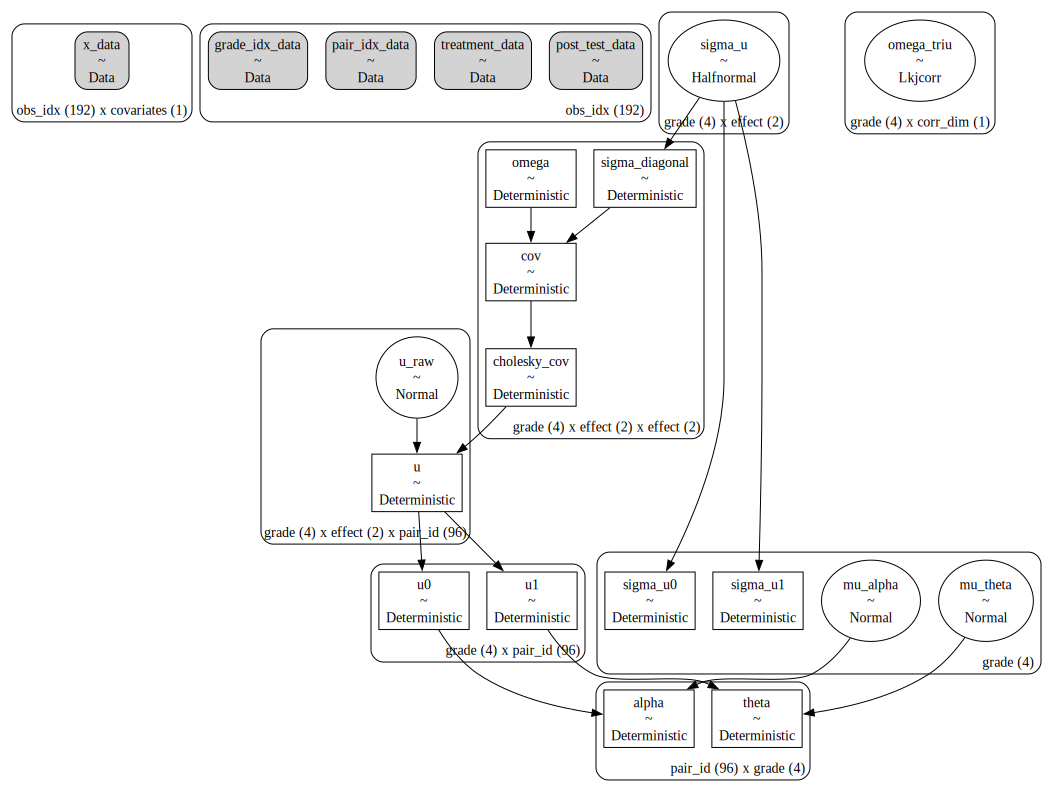

In [54]:
with pm.Model(coords=coords) as cov_model:
    # --- Data Containers ---
    # covariates
    x_data = pm.Data("x_data", x_df, dims=("obs_idx", "covariates"))
    # grade
    grade_idx_data = pm.Data("grade_idx_data", df["grade"].to_numpy(), dims="obs_idx")
    # object categories
    pair_idx_data = pm.Data("pair_idx_data", df["pair_id"].to_numpy(), dims="obs_idx")
    # treatment
    treatment_data = pm.Data(
        "treatment_data", df["treatment"].to_numpy(), dims=("obs_idx")
    )
    # outcome
    post_test_data = pm.Data(
        "post_test_data", df["post_test"].to_numpy(), dims="obs_idx"
    )

    # --- Priors ---

    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1, dims=("grade"))
    mu_theta = pm.Normal("mu_theta", mu=0, sigma=1, dims=("grade"))

    # Group-level standard deviations
    sigma_u = pm.HalfNormal("sigma_u", sigma=np.array([1, 1]), dims=("grade", "effect"))

    # Triangular upper part of the correlation matrix
    omega_triu = pm.LKJCorr("omega_triu", eta=1, n=2, dims=("grade", "corr_dim"))

    # Construct correlation matrix
    omega = pm.Deterministic(
        "omega",
        vectorized_correlation_matrices(omega_triu.eval()),
        dims=("grade", "effect", "effect"),
    )

    # Construct diagonal matrix of standard deviation
    sigma_diagonal = pm.Deterministic(
        "sigma_diagonal",
        vectorized_diagonal_matrices_v4(sigma_u),
        dims=("grade", "effect", "effect"),
    )

    # Compute covariance matrix
    cov = pm.Deterministic(
        "cov",
        pt.einsum("bij,bjk,bkl->bil", sigma_diagonal, omega, sigma_diagonal),
        dims=("grade", "effect", "effect"),
    )

    # Cholesky decomposition of covariance matrix
    cholesky_cov = pm.Deterministic(
        "cholesky_cov", pt.slinalg.cholesky(cov), dims=("grade", "effect", "effect")
    )

    # And finally get group-specific coefficients
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("grade", "effect", "pair_id"))
    u = pm.Deterministic(
        "u",
        pt.einsum("bik,bkj->bji", cholesky_cov, u_raw),
        dims=("grade", "effect", "pair_id"),
    )

    u0 = pm.Deterministic("u0", u[:, 0, :], dims=("grade", "pair_id"))
    sigma_u0 = pm.Deterministic("sigma_u0", sigma_u[:, 0], dims="grade")

    u1 = pm.Deterministic("u1", u[:, 1, :], dims=("grade", "pair_id"))
    sigma_u1 = pm.Deterministic("sigma_u1", sigma_u[:, 1], dims="grade")

    alpha = pm.Deterministic("alpha", mu_alpha + u0.T, dims=("pair_id", "grade"))
    theta = pm.Deterministic("theta", mu_theta + u1.T, dims=("pair_id", "grade"))


pm.model_to_graphviz(cov_model)